In [1]:
#Import Relevant Libraries
import math
import random
import numpy as np

from qiskit import *
from qiskit.tools.jupyter import *

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent

from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

from qiskit.quantum_info import Statevector

In [2]:
def rand_numb(low_in,high_in):
    '''
    Returns a random number between low_in and high_in, including both end points.
    '''
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

In [3]:
def append(list1, list2):
    '''
    Takes two lists and returns a list with the concatenation of both lists
    '''
    temp = []
    temp.extend(list1)
    temp.extend(list2)
    return temp

In [4]:
def createActual(x, L):
    '''
    Takes a number and a size and returns a list of length l with all entries x.
    '''
    temp = []
    for i in range(L):
        temp = np.append(temp, x)
    return temp

In [5]:
'''
Define variables for the number of layers of the two provers and the number of qubits of the provers.
'''
numLayerState = 2
numLayerMax = 2
numQubitState = 2
numQubitMax = 3

In [6]:
'''
Defines parameters that specify the unitary extension of channel 1
'''
unitary_param_1 = np.array([])
for i in range(0, 4):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

In [7]:
'''
Defines parameters that specify the unitary extension of channel 2
'''
unitary_param_2 = np.array([])
for i in range(0, 4):
    unitary_param_2 = np.append(unitary_param_2, np.array([rand_numb(0,2*np.pi)]))

In [8]:
unitary_param_1 = [0.65523857, 5.36749967, 4.08036963, 0.83121276]
unitary_param_2 = [1.28317084, 1.99895141, 4.21274631, 1.10246348]

In [9]:
'''
Create unitary extension of Channel 1
'''
size = 2
qc1 = QuantumCircuit(size)
for j in range(2):
    for i in range(size):
        qc1.rx(unitary_param_1[i+j*size], i)

    for i in range(size-1):
        qc1.cx(i, i+1)

qc1.draw()

┌─────────────┐      ┌────────────┐     
q_0: ┤ Rx(0.65524) ├──■───┤ Rx(4.0804) ├──■──
     └┬────────────┤┌─┴─┐┌┴────────────┤┌─┴─┐
q_1: ─┤ Rx(5.3675) ├┤ X ├┤ Rx(0.83121) ├┤ X ├
      └────────────┘└───┘└─────────────┘└───┘

In [10]:
'''
Create unitary extension of Channel 2
'''
size = 2
qc2 = QuantumCircuit(size)
for j in range(2):
    for i in range(size):
        qc2.rx(unitary_param_2[i+j*size], i)

    for i in range(size-1):
        qc2.cx(i, i+1)

qc2.draw()

┌────────────┐     ┌────────────┐     
q_0: ┤ Rx(1.2832) ├──■──┤ Rx(4.2127) ├──■──
     ├───────────┬┘┌─┴─┐├────────────┤┌─┴─┐
q_1: ┤ Rx(1.999) ├─┤ X ├┤ Rx(1.1025) ├┤ X ├
     └───────────┘ └───┘└────────────┘└───┘

In [14]:
def createStateProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized state prover. 
    '''
    numParam = 2*numQubit*numLayer
    stateProver = QuantumCircuit(numQubit)
    state_param_vector = ParameterVector("state_params", numParam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            stateProver.rx(state_param_vector[j*2*numQubit + i], i)
            stateProver.ry(state_param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            stateProver.cx(i, i+1)
            
    return stateProver

In [15]:
def createMaxProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized max prover. 
    '''
    numParam = 2*numQubit*numLayer
    maxProver = QuantumCircuit(numQubit)
    max_param_vector = ParameterVector("max_params", numParam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            maxProver.rx(max_param_vector[j*2*numQubit + i], i)
            maxProver.ry(max_param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            maxProver.cx(i, i+1)
            
    return maxProver

In [16]:
def createQuantumCircuit(numQubitState, numQubitMax, numLayerState, numLayerMax):
    '''
    Creates quantum circuit for the problem. 
    Refer to Fig 8. https://arxiv.org/pdf/2108.08406.pdf.
    '''
    circ = QuantumCircuit(6)
    
    #Creates maximally entangled state
    circ.h(0)
    circ.cx(0, 1)

    #Appends state prover
    circ.append(createStateProver(numQubitState, numLayerState), [3, 4])

    #Appends first controlled unitary
    circ.x(0)
    controlled_qc1 = qc1.to_gate().control(1)
    circ.append(controlled_qc1, [0, 2, 3])
    circ.x(0)

    #Appends second controlled unitary
    controlled_qc2 = qc2.to_gate().control(1)
    circ.append(controlled_qc2, [1, 2, 3])

    #Appends max prover
    circ.append(createMaxProver(numQubitMax, numLayerMax), [0, 2, 5])

    circ.cx(0, 1)
    circ.h(0)

    return circ

In [17]:
'''
Creates the quantum circuit.
'''
qCirc = createQuantumCircuit(numQubitState, numQubitMax, numLayerState, numLayerMax)
qCirc.draw()

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
«                                                                          ┌───┐                                                                      »
«q_0: ─────────────────────────────────────────────────────────────────────┤ H ├──────────────────────────────────────────────────────────────────────»
«                                                                          └───┘                                                                      »
«q_1: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
«                                                                                                                                                     »
«q_2: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_3: ┤0                                                                                                                                             ├»
«     │  circuit-13(state_params[0],state_params[1],state_params[2],state_params[3],state_params[4],state_params[5],state_params[6],state_params[7]) │»
«q_4: ┤1                                                                                                                                             ├»
«     └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«q_5: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
«                                                                                                                                                     »
«          ┌───┐                   ┌───┐     »
«q_0: ──■──┤ X ├──────■────────────┤ X ├─────»
«     ┌─┴─┐└───┘      │            └───┘     »
«q_1: ┤ X ├───────────┼──────────────■───────»
«     └───┘     ┌─────┴──────┐┌──────┴──────┐»
«q_2: ──────────┤0           ├┤0            ├»
«               │  circuit-9 ││  circuit-10 │»
«q_3: ──────────┤1           ├┤1            ├»
«               └────────────┘└─────────────┘»
«q_4: ───────────────────────────────────────»
«                                            »
«q_5: ───────────────────────────────────────»
«                                            »
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                                                                       ├»
«     │                                                                                                                                                                                        │»
«q_1: ┤                                                                                                                                                                                        ├»
«     │                                                                                                                                                                                        │»
«q_2: ┤1                                                                                                                                                                                       ├»
«     │  circuit-36(max_params[0],max_params[1],max_params[2],max_params[3],max_params[4],max_params[5],max_params[6],max_params[7],max_params[8],max_params[9],max

In [242]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
backend = Aer.get_backend('statevector_simulator')
q_instance = QuantumInstance(backend)
sampler = CircuitSampler(q_instance)

In [149]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation. 
'''
#Replace the provider with your personal credentials for hub, group and main
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")

backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
sampler = CircuitSampler(quantum_instance)

In [243]:
'''
Average value of this hamiltonian is the probability of measuring 00 on the first two qubits.
MatrixOp(np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])) is the projector on the 00 subspace on
the first two qubits. Qiskit orders qubits in reverse.
'''
hamiltonian = I^I^I^I^MatrixOp(np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]))

In [244]:
'''
Creates global variables that are used in the optimization. 
'''
global param_state
global param_max

In [245]:
def costf(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the expectation value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    result = sampler.convert(expectation, params=value_dict).eval()  
    return np.real(result)

In [246]:
def gradient(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the gradient of the costf with respect
    to each parameter.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    result = sampler.convert(gradient, params=value_dict).eval()
    return np.real(result)

In [247]:
def costf_state(params):
    '''
    Assigns the params input to the parameters of the state prover, and calculates the expectation value.
    For the max prover parameters, uses the global values.
    '''
    temp = append(param_max, params)
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, temp))
    result = sampler.convert(expectation, params=value_dict).eval()  
    return np.real(result)

In [248]:
def costf_max(params):
    '''
    Assigns the params input to the parameters of the max prover, and calculates the expectation value.
    For the state prover parameters, uses the global values.
    Note: We return the negative of the expectation value because the optimizer only allows for minimization and we 
    want to maximize. 
    '''
    temp = append(params, param_state)
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, temp))
    result = sampler.convert(expectation, params=value_dict).eval()  
    return -1*np.real(result)

In [249]:
def gradient_state(params):
    '''
    Assigns the params input to the parameters of the state prover, and calculates the gradient of the costf with 
    respect to the state prover parameters.
    For the max prover parameters, uses the global values.
    '''
    temp = append(param_max, params)
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    gradient = Gradient().convert(expectation, qCirc.parameters[numParamMax:])
    value_dict = dict(zip(qCirc.parameters, temp))
    result = sampler.convert(gradient, params=value_dict).eval()
    return np.real(result)

In [250]:
def gradient_max(params):
    '''
    Assigns the params input to the parameters of the max prover, and calculates the gradient of the costf with 
    respect to the max prover parameters.
    For the state prover parameters, uses the global values.
    Note: We return the negative of the gradient value because the optimizer only allows for minimization and we 
    want to maximize. 
    '''
    temp = append(params, param_state)
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    gradient = Gradient().convert(expectation, qCirc.parameters[:numParamMax])
    value_dict = dict(zip(qCirc.parameters, temp))
    result = sampler.convert(gradient, params=value_dict).eval()
    return -1*np.real(result)

In [251]:
#Array to store the loss function values
loss = []

def autospsa_callback_min(nfev, x, fx, stepsize, accepted = False):
    '''
    Callback function called automatically during optimization. Append loss value and print every 10 iterations with 
    a completion percentage.
    '''
    loss.append(fx)
    if (nfev % 30 == 0):
        print("Loss Value : ", fx, str(nfev/3)+"%")
    
def gd_callback_max(nfevs, x, fx, stepsize):
    '''
    Callback function called automatically during optimization. Append loss value and print every iteration.
    '''
    loss.append(-1*fx)
    print("Loss Value : ", -1*fx)

In [253]:
'''
Initialize state and max prover parameters to random angles
'''
numParamState = 2*numQubitState*numLayerState
numParamMax = 2*numQubitMax*numLayerMax

param_state = []
for i in range(0, numParamState):
    param_state = np.append(param_state, np.array([rand_numb(0,2*np.pi)]))

param_max = []
for i in range(0, numParamMax):
    param_max = np.append(param_max, np.array([rand_numb(0,2*np.pi)]))

print("Initial Cost : ", costf(append(param_max, param_state)))

Initial Cost :  0.16734098236208794


In [254]:
'''
Minimizer runs to convergence. Maximizer takes one step.
'''
for i in range(60):
    print("Iteration Number :", i)
    
    print("Minimizer")
    autospsa = SPSA(maxiter=100, learning_rate=0.5, perturbation=0.05, callback=autospsa_callback_min)
    x_opt, fx_opt, nfevs = autospsa.optimize(numParamState, costf_state, gradient_function=gradient_state, initial_point=param_state)
    param_state = x_opt

    print("Maximizer")
    gd = GradientDescent(maxiter=1, learning_rate=0.5, callback=gd_callback_max)
    x_opt, fx_opt, nfevs = gd.optimize(numParamMax, costf_max, gradient_function=gradient_max, initial_point=param_max)
    param_max = x_opt

Iteration Number : 0
Minimizer
Loss Value :  0.15086135787089652 10.0%
Loss Value :  0.14435843422821526 20.0%
Loss Value :  0.14408552208019854 30.0%
Loss Value :  0.14376316214519919 40.0%
Loss Value :  0.14338338779094584 50.0%
Loss Value :  0.14323146486228674 60.0%
Loss Value :  0.14312551181551902 70.0%
Loss Value :  0.14301988954699663 80.0%
Loss Value :  0.14291810390674678 90.0%
Loss Value :  0.14286417220444542 100.0%
Maximizer
Loss Value :  0.16738083110225613
Iteration Number : 1
Minimizer
Loss Value :  0.16735851719156583 10.0%
Loss Value :  0.16734371456584712 20.0%
Loss Value :  0.16732131805905728 30.0%
Loss Value :  0.16730142733173572 40.0%
Loss Value :  0.16728683898304691 50.0%
Loss Value :  0.16727682385776246 60.0%
Loss Value :  0.16727184638994896 70.0%
Loss Value :  0.1672664929201048 80.0%
Loss Value :  0.16726395431711263 90.0%
Loss Value :  0.16726109604654432 100.0%
Maximizer
Loss Value :  0.19728984335448324
Iteration Number : 2
Minimizer
Loss Value :  0.19

Loss Value :  0.8183105111366532 70.0%
Loss Value :  0.8175202517467974 80.0%
Loss Value :  0.8172132232297498 90.0%
Loss Value :  0.8170745793245456 100.0%
Maximizer
Loss Value :  0.8722385081334261
Iteration Number : 18
Minimizer
Loss Value :  0.8722117773781103 10.0%
Loss Value :  0.8721808078534906 20.0%
Loss Value :  0.8721588084692394 30.0%
Loss Value :  0.87213884036727 40.0%
Loss Value :  0.8721250755863899 50.0%
Loss Value :  0.8721150051237399 60.0%
Loss Value :  0.872107762463659 70.0%
Loss Value :  0.8720882498137945 80.0%
Loss Value :  0.8720757640658274 90.0%
Loss Value :  0.8720690848606493 100.0%
Maximizer
Loss Value :  0.9133953894088428
Iteration Number : 19
Minimizer
Loss Value :  0.9133893240458337 10.0%
Loss Value :  0.9133858025132962 20.0%
Loss Value :  0.9133743702137861 30.0%
Loss Value :  0.9133655850250815 40.0%
Loss Value :  0.9133555330205922 50.0%
Loss Value :  0.9133480961239409 60.0%
Loss Value :  0.9133441908870468 70.0%
Loss Value :  0.9133397771264707

Loss Value :  0.9215048526804897 30.0%
Loss Value :  0.9214178074376522 40.0%
Loss Value :  0.9212997799617269 50.0%
Loss Value :  0.9211853262537946 60.0%
Loss Value :  0.9211099948838716 70.0%
Loss Value :  0.9209378810233548 80.0%
Loss Value :  0.9208827797404959 90.0%
Loss Value :  0.9207440494278906 100.0%
Maximizer
Loss Value :  0.9246543362726382
Iteration Number : 36
Minimizer
Loss Value :  0.9240437291948791 10.0%
Loss Value :  0.9234326691399003 20.0%
Loss Value :  0.9217931212576307 30.0%
Loss Value :  0.9212310695155494 40.0%
Loss Value :  0.9203009565250511 50.0%
Loss Value :  0.9197520271028802 60.0%
Loss Value :  0.9194979648412543 70.0%
Loss Value :  0.9184903147216172 80.0%
Loss Value :  0.9176183398728657 90.0%
Loss Value :  0.916837572825997 100.0%
Maximizer
Loss Value :  0.9280693678355589
Iteration Number : 37
Minimizer
Loss Value :  0.9273463384172737 10.0%
Loss Value :  0.9248164586437463 20.0%
Loss Value :  0.9238245378577181 30.0%
Loss Value :  0.92201910342758

Loss Value :  0.9287955969941604
Iteration Number : 53
Minimizer
Loss Value :  0.9276589694640132 10.0%
Loss Value :  0.9266333923049722 20.0%
Loss Value :  0.925093291965349 30.0%
Loss Value :  0.9235674165402419 40.0%
Loss Value :  0.921325325273264 50.0%
Loss Value :  0.9200520850721194 60.0%
Loss Value :  0.9182700291103272 70.0%
Loss Value :  0.9167726725379005 80.0%
Loss Value :  0.9156808662562514 90.0%
Loss Value :  0.9152551528293182 100.0%
Maximizer
Loss Value :  0.9237893830207246
Iteration Number : 54
Minimizer
Loss Value :  0.9236962526895849 10.0%
Loss Value :  0.9235847458749908 20.0%
Loss Value :  0.9234225795356164 30.0%
Loss Value :  0.9233533164631543 40.0%
Loss Value :  0.923159252802758 50.0%
Loss Value :  0.9229900947587915 60.0%
Loss Value :  0.9229492060280003 70.0%
Loss Value :  0.9228933760863679 80.0%
Loss Value :  0.9228313773509833 90.0%
Loss Value :  0.9226732289293578 100.0%
Maximizer
Loss Value :  0.9233680524922194
Iteration Number : 55
Minimizer
Loss V

In [255]:
'''
Print optimal parameter values.
'''
print(param_max)
print(param_state)

[3.14155402 2.15906596 3.98345272 3.14171865 1.90541154 5.81658476
 6.28314675 3.14499924 4.55111713 6.28305928 1.57829406 3.4736459 ]
[ 1.15377583  0.66815647  4.38763627  2.79271718 -0.07818717  2.45767354
  5.29899828  3.70089278]


In [196]:
param_max_noisy = param_max
param_state_noisy = param_state
print("Noisy Final Cost : ", costf(append(param_max_noisy, param_state_noisy)))

Noisy Final Cost :  0.9170660502448642


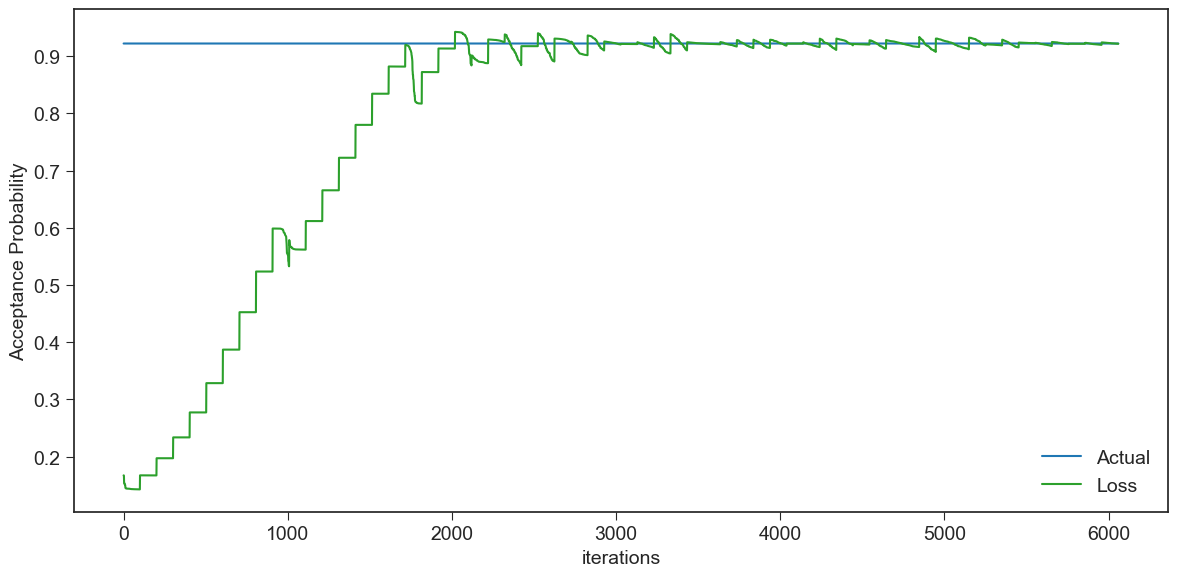

In [256]:
def plot_loss():
    '''
    Plots loss function. Actual root fidelity value can be calculated using SDP.
    '''
    start_point = 0
    plt.figure(figsize=(12, 6))
    plt.plot(createActual(0.5*(1+0.8442359418114711), len(loss[start_point:])), label = 'Actual')
    plt.plot(loss[start_point:], 'tab:green', label='Loss')
    plt.ylabel('Acceptance Probability')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()
plot_loss()

In [257]:
loss_noiseless = []
loss_noiseless = append(loss_noiseless, loss)

In [164]:
loss_noisy = []
loss_noisy = append(loss_noisy, loss)

In [1]:
#Calculate Fidelity from Acceptance Probability
fid_noiseless = [2*i-1 for i in loss_noiseless]
fid_noisy = [2*i-1 for i in loss_noisy]

NameError: name 'loss_noiseless' is not defined

<ipython-input-227-29731a410d7d>:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("FidelityChannelsNoisy.pdf", dpi=2000, format='pdf', bbox_extra_artists=(), bbox_inches='tight')
<ipython-input-227-29731a410d7d>:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("FidelityChannelsNoisy.pdf", dpi=2000, format='pdf', bbox_extra_artists=(), bbox_inches='tight')
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


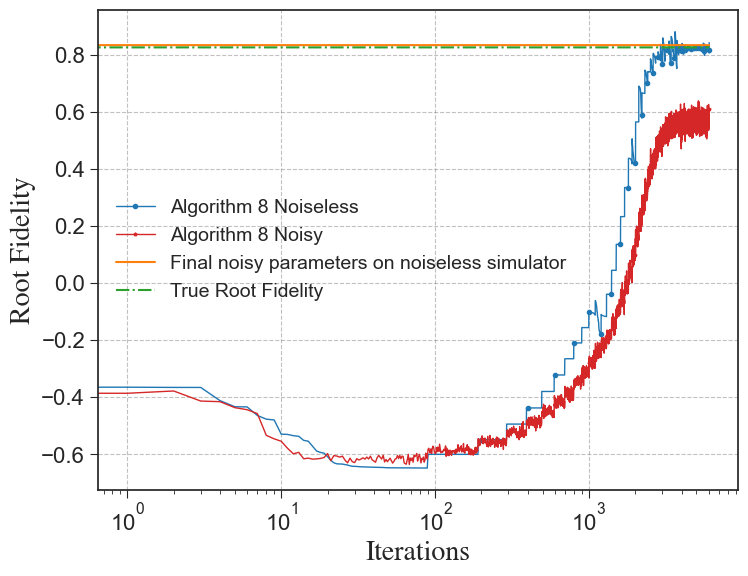

In [227]:
'''
To generate graph Figure 8 from https://arxiv.org/pdf/2108.08406.pdf
'''
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter, LogLocator
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
from matplotlib import rc

#import rhinoscriptsytnax as rs

c1 = '#14A76C'
c6 = '#AC3B61'
c4 = '#2B7A78'
c2 = '#2E9CCA'
c5 = '#29648A'
c3 = '#F76C6C'

#m,c,k,g,r,b

#plt.rcParams['text.usetex'] = True
timesfont = {'fontname':'Times'}
style.use('seaborn-ticks')

start = 10
end = 20000

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# Plot and show our data
ax.plot(fid_noiseless[start:end],'-o', markersize=3, markevery=200, color = '#1f77b4', linewidth=1.0, label = 'Algorithm 8 Noiseless')
ax.plot(fid_noisy[start:end],'-p', markersize=2, markevery=1000, color = "#d62728", linewidth=1.0, label = 'Algorithm 8 Noisy')
ax.plot(createActual(2*0.9170660502448642-1, len(loss[start:end])), color = '#ff7f0e', label = 'Final noisy parameters on noiseless simulator')
ax.plot(createActual(0.8261831126529322, len(loss[start:end])), '-.', color = '#2ca02c', label = 'True Root Fidelity')
ax.set_xscale('log')
#ax.set_xlim(0, 1600)
ax.legend(loc=0)

ax.grid(b=True, which='major', color='#666666', linestyle='--',alpha=0.4)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Iterations',**timesfont,fontsize =20)
ax.set_ylabel('Root Fidelity',**timesfont,fontsize =20)
#ax.set_xlabel('Iterations', labelpad=1)
#ax.set_ylabel('Fidelity', labelpad=10)
plt.savefig("FidelityChannelsNoisy.pdf", dpi=2000, format='pdf', bbox_extra_artists=(), bbox_inches='tight')
plt.show()